# `DeepGalerkin`-model: solving PDEs with NNs

Welcome! In this tutorial you'll learn how to solve partial differential equations (PDEs) with neural networks using `DeepGalerkin`-model from `BatchFlow`, inspired by the paper [DGM: A deep learning algorithm for solving partial differential equations](http://arxiv.org/abs/1708.07469). The notebook
* starts with general setup of the PDE solved by `DeepGalerkin`
* then explains in detail how the model is configured
* finally, demonstrates how to use the model for solving common pde-problems, including *[heat-equation](https://en.wikipedia.org/wiki/Heat_equation)* and *[wave-equation](https://en.wikipedia.org/wiki/Wave_equation)*.

To get full understanding of `DeepGalerkin`, we suggest you to read this tutorial starting from the problem setup. The alternative is to jump straight to the working examples:
* [first-order ode $\mathcal{R}$](#ex1)
* [poisson equation in $\mathcal{R}^2$](#ex2)
* [heat equation in $\mathcal{R}^2 \times \mathcal{R}$](#ex3)
* [wave equation in $\mathcal{R}$](#ex4)

**Note**: `DeepGalerkin` is written in [TensorFlow](https://www.tensorflow.org/). Throughout the notebook `tf` will stand for `TensoFlow`.

## Setup of the PDE-problem

Currently, `DeepGalerkin` supports equations of up to the second order with constant coefficients with `Dirichlet` boundary and initial conditions. In general form, the PDE-
problem looks as follows:
<a id='eq'></a>
$$
\sum_i a_i \frac{\partial u}{\partial x_i} + \sum_{i j} b_{i j} \frac{\partial^2 u}{\partial x_i \partial x_i}  = Q(x). \\
$$
Where $a_{ij}, b_i $ -  arbitrary constants. PDE is solved on the domain
<a id='dom'></a>
$$
\Omega = [b_0^1, b_1^1] \times \dots \times [b_0^n, b_1^n] ,\quad u: \mathcal{R}^n \rightarrow \mathcal{R}
$$
$x$ is $(x_1, \dots, x_n)$. In many tasks, $x_n$ represents time-dimension $t$. In that case, the initial conditions fix the initial state and evolution rate of the system:
<a id='inc_0'></a>
$$
u(x_1, \dots, x_{n-1}, b_0^n) = u_0(x_1, \dots, x_{n-1}),
$$
<a id='inc_1'></a>
$$
\frac{\partial u(x_1, \dots, x_{n-1}, b_0^n)}{\partial t} = u_0'(x_1, \dots, x_{n-1}).
$$
When only first-order time derivative is presented in lhs of PDE, only the initial value of system is needed:
$$
u(x_1, \dots, x_{n-1}, b_0^n) = u_0(x_1, \dots, x_{n-1}).
$$
`DeepGalerkin` also uses constant `Dirichlet`-boundary conditions:
<a id='inc_3'></a>
$$
u(\sigma \Omega) = u_{\sigma} = const.
$$

The main idea of `DeepGalerkin` is to fit the parameters $\theta$ of network $net(x; \theta)$ so that the difference between left-hand-side (lhs) of the PDE and right-hand-size (rhs) be small:
<a id='dist'></a>
$$
e(x) = \sum_i a_i \frac{\partial net(x; \theta)}{\partial x_i} + \sum_{i j} b_{i j} \frac{\partial^2 net(x; \theta)}{\partial x_i \partial x_i} - Q(x),
$$
$$
Loss(\theta) = \int\limits_{\Omega} L\left[e(x)\right] \mathcal{P}( d x),
$$
$$
Loss(\theta) \rightarrow \min\limits_{\theta}.
$$
**Note:** In practice, $Loss(\theta)$ is estimated on a sample(batch) of points $\{(x^i_1,\dots, x^i_n)\}_{i=1,\dots,N}$.
As the distribution $\mathcal{P}$ is not fixed, any sampling scheme can be used.

## Configuring `DeepGalerkin`

Configuring `DeepGalerkin` comes down to
* specification of the equation solved by the model in `pde`-dict
* setting other parameters of the model inherited from base-class [`batchflow.models.TfModel`](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.base.html), e.g. network-architecture and loss-function
* configuring how to form batches of training data and feed them into the training loop
* [optional] specifying gradients for tracking (for instance, for debugging purposes)

### 1.PDE setup in `pde`-dict

It consists of several steps:
* describing lhs of the [equation](#eq): define coefficients $a_{i}, b_{ij}$. This corresponds to the key `form`:
```
'form' : {'d1': v, 'd2': m}
```
where `v` is a vector of $a_i$ and $m$ is a matrix of $b_{ij}$. The number of coefficients in $v$ (alternatively, rows/lines in $m$) defines the dimensionality of the problem.
* setting rhs ($Q$) of the [equation](#eq):
```
'rhs' : tf_callable
```
where `tf_callable` is a callable, that accepts `tf`-tensor of shape `(batch_size, pde_dimensionality)` and returns a `tf`-tensor of shape `(batch_size, )`.
* defining the [domain](#dom) of the problem:
```
'domain' : [[b_0^1, b_1^1],...,[b_0^n, b_1^n]]
```
**Note**: if the key is not specified, the domain is set to `[[0, 1],...,[0, 1]]`
* setting initial/boundary conditions. In case of PDEs with time-variable, e.g. heat-equation, one needs to fix initial value of the system ($u(x_1, \dots, x_n, t=0)$) using `initial_condition`:
```
'initial_condition': tf_callable
```
where `tf_callable` accepts `tf`-tensor of shape `(batch_size, pde_dimensionality - 1)` and returns `tf`-tensor of shape `(batch_size, )`. Importantly, when $\frac{\partial^2{u}}{\partial{t^2}}$ is presented in lhs of the equation (e.g. [wave equation](#eq)), one needs to fix **both** initial value and initial rate of the system ($\frac{\partial{u}}{\partial{t}}(x_1, \dots, x_n, t=0)$):
```
'initial_condition': (tf_callable_1, tf_callable_2)
```
When `initial_condition` is not present in configuration-dict, `boundary-condition` [$u_{\sigma}$](#inc_3) must be supplied:
```
'boundary_condition': constant
```
* [optional] choosing the mode of `time_multiplier`: a multiplier, used for binding initial conditions. Can be either `sigmoid` or `polynomial` or callable. Go [here](https://github.com/analysiscenter/batchflow/blob/deep_galerkin/batchflow/models/tf/deep_galerkin.py#L150) for more info.

### 2. Setting other parameters of `DeepGalerkin`

The easiest way to choose the architecture of network $net(x; \theta)$ is to use [batchflow's convolution block](https://analysiscenter.github.io/batchflow/intro/tf_layers.html) in [network's body](https://analysiscenter.github.io/batchflow/intro/tf_models.html). For instance, this combination of keys
```
'body':{'layout' : 'fa fa f',
        'units' : [10, 15, 1],
        'activation' : [tf.nn.tanh, tf.nn.tanh]}
```
corresponds to a `f`ully-connected network with two hidden layers (of 10 and 15 units), one output-unit and two `tanh`-`a`ctivations. The specification of `loss` and other parameters is straightforward:
```
'loss':'mse'
```

### 3. Setting up the data-feeding procedure
It consists of two steps

* choosing the sampling scheme from $\Omega$ (fixing the distribution $\mathcal{P}$).
The most convenient way is to use [`Sampler`-class](https://github.com/analysiscenter/batchflow/blob/master/examples/tutorials/07_sampler.ipynb). For instance, this line
```
s = (0.5 + NumpySampler('normal', dim=2)).truncate((1, 1), (0, 0)) 
```
creates an object, that can sample points from a 2-dimensional Gaussian with center at $(0.5, 0.5)$ truncated into the box $[0, 1] \times [0, 1]$:
```
sample_of_size_10 = s.sample(size=10)
```
* feeding sampled batches into the network-training loop. The easiest way is to wrap a callable, that samples points (`s.sample` in our example), into a [batchflow's named expression L](https://analysiscenter.github.io/batchflow/intro/named_expr.html):
```
train = (Pipeline()
         .init_model(name='galerkin', ...)
         .train_model('galerkin',
                      feed_dict={'points': L(s.sample, size=F(len))} # wrap sampler
                      ))
```

### 4. Tracking gradients of $net(x, \theta)$ w.r.t its input $x$.

Sometimes the network does not seem to train at all. In this case, it may be useful to take a look at terms forming the [loss](#dist): first/second order derivatives of network-output with respect to its input-coordinates:

$$
\frac{\partial net(x; \theta)}{\partial x_i},\ \frac{\partial^2 net(x; \theta)}{\partial x_i^2},\
\frac{\partial^2 net(x; \theta)}{\partial x_i \partial x_j}
$$

It is as simple as adding the following key to the model-config:

```
'output': ['d1x0',   # first-order derivative w.r.t. first coordinate
           'd1x',    # "x", "y", "z" stand for first three coordinates 
           'd2t',    # ..while "t" stands for the last one
           'd2xy']   # mixed derivatives can also be tracked
```

There is also possibility of tracking any expression with the same structure as left-hand side. For example, to track
$$
\frac{\partial^2 net(x; \theta)}{\partial x^2} + \frac{\partial^2 net(y; \theta)}{\partial y^2}
$$
you need to add following key to the model-config:

```
'track': {'my_expression': {'d2': np.eye(2)}} 
```

## Examples: Solving common PDEs with `DeepGalerkin`

In [1]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
from batchflow.models.tf import DeepGalerkin
from batchflow import Pipeline, L, F, V, DatasetIndex, Dataset
import numpy as np
from batchflow import NumpySampler
from batchflow.sampler import cart_prod
from tqdm import tqdm_notebook

<a id='ex1'></a>

* first-order ordinary differential equation in $\mathcal{R}$ with simple initial condition
$$
\frac{d f}{d t}= 2\pi\cos[2 \pi t]; \quad t \in [0, 1],\ f(0)=1.
$$

In [2]:
# describing pde-problem in pde-dict
pde = {'form': {'d1': (1, )},
       'rhs': lambda t: 2 * np.pi * tf.cos(2 * np.pi * t),
       'initial_condition': 1}   # will be transformed into callable returning 1

# network-architecture and loss-function
body = {'layout': 'fa fa f',
        'units': [10, 15, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'body': body,
          'pde': pde,
          'loss': loss,
          'output': 'dt'}   # track dnet/dt

# uniform sampling scheme
s = NumpySampler('uniform')

In [3]:
# assemble training pipeline
pipeline = (Pipeline()
            .init_variable('loss', default=[])
            .init_variable('dt', default=[])
            .init_model('static', DeepGalerkin, 'DG', config)
            .train_model('DG',
                         feed_dict={'points': L(s.sample, size=F(len))},
                         fetches='loss',
                         save_to=V('loss'), mode='a'))

dsix = DatasetIndex(np.arange(100))
pipeline_ds = Dataset(dsix) >> pipeline

# train the network on batches of 20 points
for i in tqdm_notebook(range(2000)):
    pipeline_ds.next_batch(100, n_epochs=None)

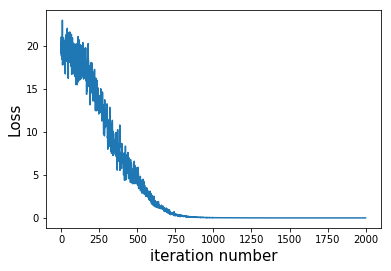

In [4]:
# plot loss
plt.plot(pipeline_ds.get_variable('loss')[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.show()

In [5]:
# fetch trained model
dg = pipeline_ds.get_model_by_name('DG')

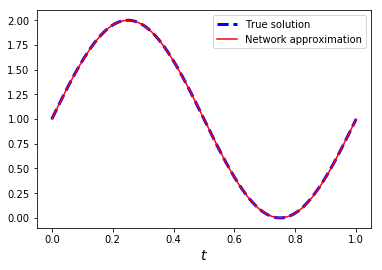

In [6]:
# plot real solution and network approximation
sol = lambda t: np.sin(2 * np.pi * t) + 1
pts = np.linspace(0, 1, 200).reshape(-1, 1)
approxs = dg.predict(feed_dict={'points': pts})
true = [sol(t[0]) for t in pts]
plt.plot(pts, true, 'b--', linewidth=3, label='True solution')
plt.plot(pts, approxs, 'r', label='Network approximation')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.show()

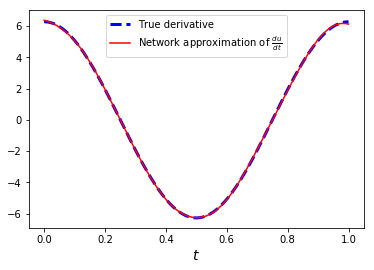

In [7]:
# plot approximation of solution-derivative
der = lambda t: 2 * np.pi * np.cos(2 * np.pi * t)
true_der = [der(t[0]) for t in pts]
ders = dg.predict(fetches='dt', feed_dict={'points': pts})
plt.plot(pts, true_der, 'b--', linewidth=3, label=r'True derivative')
plt.plot(pts, ders, 'r', label=r'Network approximation of $\frac{d u}{d t}$')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.show()

<a id='ex2'></a>

* poisson equation in $\mathcal{R}^2$ with Dirichlet boundary condition

$$\frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = 5\sin[\pi(x + y)];\quad (x, y) \in [0, 1]^2,\ f(0, y)=f(x, 0)=f(1, y)=f(x, 1)=1.
$$

In [8]:
# describing pde-problem in pde-dict
pde = {'form': {'d2': ((1, 0), (0, 1))},
       'rhs': lambda x: 5 * tf.sin(np.pi * tf.reduce_sum(x, axis=1, keepdims=True)),
       'boundary_condition': 1}                       # will be transformed into callable returning 1

# network-architecture and loss-function
body = {'layout': 'fa fa fa f',
        'units': [15, 25, 15, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'body': body,
          'pde': pde,
          'loss': loss,
          'track': {'d2x+d2y': {'d2': np.eye(2)}}}    # another way of tracking additional expressions

# uniform sampling scheme (using alias)
s = NumpySampler('u', dim=2)

In [9]:
# assemble training pipeline
pipeline = (Pipeline()
            .init_variable('loss', default=[])
            .init_variable('dt', default=[])
            .init_model('static', DeepGalerkin, 'DG', config)
            .train_model('DG',
                         feed_dict={'points': L(s.sample, size=F(len))},
                         fetches='loss',
                         save_to=V('loss'), mode='a'))

dsix = DatasetIndex(np.arange(100))
pipeline_ds = Dataset(dsix) >> pipeline

# train the network on batches of 50 points
for i in tqdm_notebook(range(1500)):
    pipeline_ds.next_batch(50, n_epochs=None)

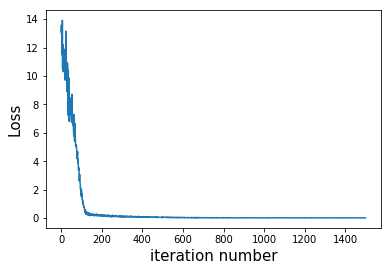

In [10]:
# plot loss
plt.plot(pipeline_ds.get_variable('loss')[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.show()

In [11]:
# fetch trained model
dg = pipeline_ds.get_model_by_name('DG')

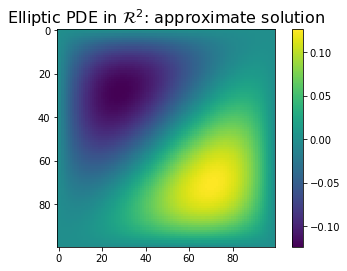

In [12]:
# plot network approximation of a solution
n_el = 100
grid = cart_prod(np.linspace(0, 1, n_el), np.linspace(0, 1, n_el))
approxs = dg.predict(feed_dict={'points': grid})
plt.title('Elliptic PDE in $\mathcal{R}^2$: approximate solution', fontdict={'fontsize': 16})
plt.imshow(approxs.reshape(n_el, n_el))
plt.colorbar()
plt.show()

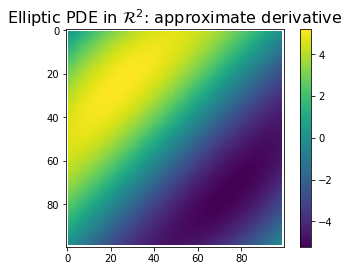

In [13]:
# plot approximation of solution-derivative
ders = dg.predict(fetches='d2x+d2y', feed_dict={'points': grid})
plt.title('Elliptic PDE in $\mathcal{R}^2$: approximate derivative', fontdict={'fontsize': 16})
plt.imshow(ders.reshape(n_el, n_el))
plt.colorbar()
plt.show()

<a id='ex3'></a>

* heat equation in $\mathcal{R}^2 \times \mathcal{R}$

$$\frac{\partial f}{\partial t} - \frac{\partial^2 f}{\partial x^2} - \frac{\partial^2 f}{\partial y^2} = 5xy(1 - x)(1 - y) \cos[\pi(x + y)];\quad (x, y, t) \in [0, 1]^2 \times [0, 1],\ f(x, y, 0) = xy(1 - x)(1 - y).
$$

In [14]:
# describing pde-problem in pde-dict
pde = {'form': {'d2': ((-1, 0, 0), (0, -1, 0), (0, 0, 0)),
                'd1': (0, 0, 1)},
       'rhs': lambda x: (5 * tf.cos(np.pi * tf.reduce_sum(x[:, :2], axis=1, keepdims=True))
                         * tf.reduce_prod(x[:, :2], axis=1, keepdims=True)
                         * tf.reduce_prod(1 - x[:, :2], axis=1, keepdims=True)),
       'initial_condition': lambda x:(tf.reduce_prod(x, axis=1, keepdims=True)
                                      * tf.reduce_prod(1 - x, axis=1, keepdims=True))}

# network-architecture and loss-function
body = {'layout': 'fa fa fa f',
        'units': [15, 25, 15, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'body': body,
          'pde': pde,
          'loss': loss}

# uniform sampling scheme
s = NumpySampler('u', dim=3)

In [15]:
# assemble training pipeline
pipeline = (Pipeline()
            .init_variable('loss', default=[])
            .init_variable('dt', default=[])
            .init_model('static', DeepGalerkin, 'DG', config)
            .train_model('DG',
                         feed_dict={'points': L(s.sample, size=F(len))},
                         fetches='loss',
                         save_to=V('loss'), mode='a'))

dsix = DatasetIndex(np.arange(100))
pipeline_ds = Dataset(dsix) >> pipeline

# train the network on batches of 200 points
for i in tqdm_notebook(range(5000)):
    pipeline_ds.next_batch(100, n_epochs=None)

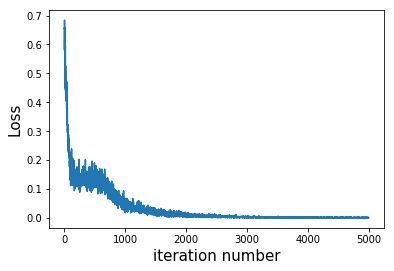

In [16]:
# plot loss
plt.plot(pipeline_ds.get_variable('loss')[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.show()

In [17]:
# fetch trained model
dg = pipeline_ds.get_model_by_name('DG')

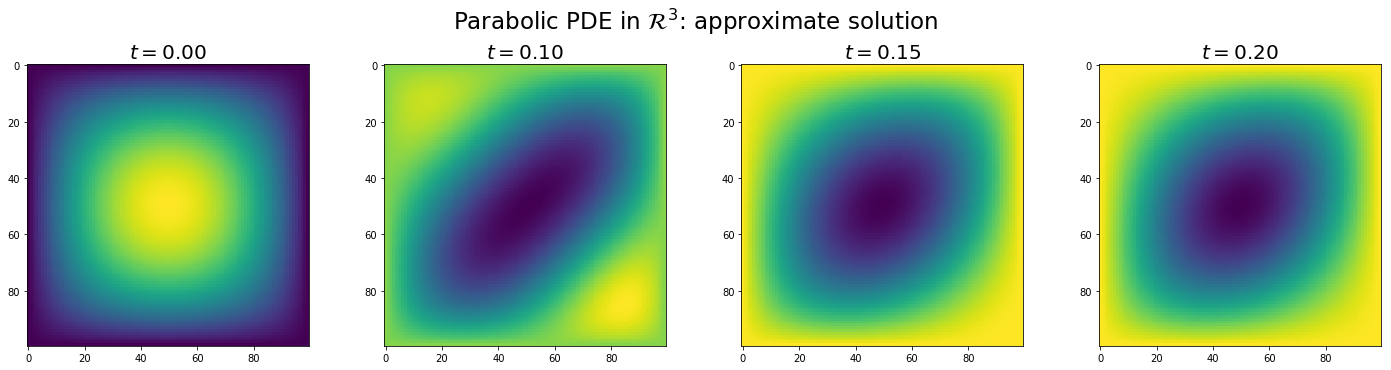

In [18]:
# plot network approximation of a solution
n_sections = 4
timestamps = (0, 0.1, 0.15, 0.2)
n_el = 100
fig, axes = plt.subplots(1, n_sections, figsize=(5 * n_sections, 5))
cart = cart_prod(np.linspace(0, 1, n_el), np.linspace(0, 1, n_el))

for i, t_ in enumerate(timestamps):
    grid = np.concatenate([cart, t_ * np.ones(shape=(n_el**2, 1))], axis=1)
    approxs = dg.predict(feed_dict={'points': grid})
    axes[i].imshow(approxs.reshape(n_el, n_el))
    axes[i].set_title('$t=%.2f$' % t_, size=20)
fig.tight_layout()
fig.suptitle('Parabolic PDE in $\mathcal{R}^3$: approximate solution', size=23)
fig.subplots_adjust(top=0.82)
fig.show()

<a id='ex4'></a>

* wave equation in $\mathcal{R} \times \mathcal{R}$ (evolution equation of plucked string with fixed ends)

$$ \frac{\partial^2 f}{\partial t^2} - \frac{\partial^2 f}{\partial x^2} = 0 ; \quad (x, t) \in [0, 1] \times [0, 1],\ f(x, 0)=x(1 - x),\ \frac{\partial f}{\partial t}(x, 0)= 0.
$$

It is reasonable to set `time_multiplier` to `polynomial` since we know that solution is oscillating endlessly.

In [29]:
# describing pde-problem in pde-dict
pde = {'form': {'d2': ((-5, 0), (0, 1))},
       'rhs': 0,
       'initial_condition': [lambda x: x * (1 - x), 0],
       'time_multiplier': 'polynomial'}

# network-architecture and loss-function
body = {'layout': 'faR fa fa+ f',
        'units': [10, 25, 10, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'body': body,
          'pde': pde,
          'loss': loss,
          'output': 'd1t'}

# uniform spatial sampling and exponential time-sampling
s = NumpySampler('u') & NumpySampler('e', scale=1).truncate(3.0)

In [30]:
# assemble training pipeline
pipeline = (Pipeline()
            .init_variable('loss', default=[])
            .init_variable('dt', default=[])
            .init_model('static', DeepGalerkin, 'DG', config)
            .train_model('DG',
                         feed_dict={'points': L(s.sample, size=F(len))},
                         fetches=['loss', 'd1t'],
                         save_to=[V('loss'), V('dt')], mode='a'))

dsix = DatasetIndex(np.arange(1000))
pipeline_ds = Dataset(dsix) >> pipeline

# train the network on batches of 1000 points
for i in tqdm_notebook(range(10000)):
    pipeline_ds.next_batch(100, n_epochs=None)

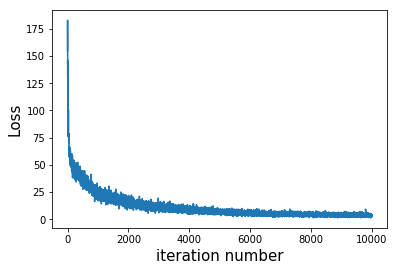

In [31]:
# plot loss
plt.plot(pipeline_ds.get_variable('loss')[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.show()

In [32]:
# fetch trained model
dg = pipeline_ds.get_model_by_name('DG')

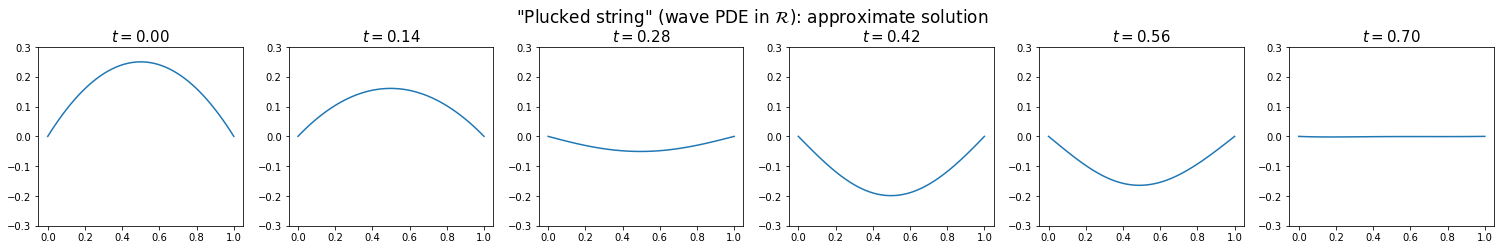

In [33]:
# plot network approximation of a solution
n_sections = 6
timestamps = (0., 0.14, 0.28, 0.42, 0.56, 0.7)
n_el = 100
fig, axes = plt.subplots(1, n_sections, figsize=(3.5 * n_sections, 3.5))
cart = np.linspace(0, 1, n_el).reshape((n_el, 1))

for i, t_ in enumerate(timestamps):
    grid = np.concatenate([cart, t_ * np.ones(shape=(n_el, 1))], axis=1)
    approxs = dg.predict(feed_dict={'points': grid})
    axes[i].plot(cart, approxs.reshape(n_el, ))
    axes[i].set_title('$t=%.2f$' % t_, size=15)
    axes[i].set_ylim(-0.3, 0.3)
    
fig.tight_layout()
fig.suptitle('"Plucked string" (wave PDE in $\mathcal{R}$): approximate solution', size=17)
fig.subplots_adjust(top=0.82)
fig.show()